# **Photo Mosaic**

The objective of this notebook is to recreate a mosaic by employing the given set of images. The ground-truth mosaic is used for comparison, and it was generated with the same set of images by a professional tool.

The implementation is separated into three steps:
1. Calculate the homography matrices between two consecutive images by employing different methods for keypoint detection (**SIFT**, **ORB** e **FAST**) and description (**SIFT**, **ORB** e **BRIEF**).
2. Transform the images employing the obtained matrices
3. Blend the images and eliminate artifacts generated by the transformation and illumination differences applying different methods.

A [discussion](#discussion) considering the obtained results is conducted at the end of the notebook.

## **Environment Preparation**

In [ ]:
pip install -U opencv-contrib-python

Requirement already up-to-date: opencv-contrib-python in /usr/local/lib/python3.6/dist-packages (4.4.0.44)


In [ ]:
import numpy
import cv2
import matplotlib.pyplot as plt

print('OpenCV version:', cv2.__version__)

OpenCV version: 4.4.0


## **Main Functions**

In [ ]:
def get_correspondences(image_1, image_2, detector, descriptor, number_features, number_macthes):
    """Generates keypoints and correspondences between two given images.

    Args: 
        image_1: [numpy.ndarray] First image
        image_2: [numpy.ndarray] Second image
        detector: [string] Name of the detector to use
        descriptor [string] Name of the descriptor to use
        number_features: [int] Limit of features to detect
        number_macthes: [int] Limit of best matches to use

    Returns:
        keypoints_1: [cv.KeyPoint] Keypoints list for the first image
        keypoints_2: [cv.KeyPoint] Keypoints list for the second image
        matches: [cv.DMatch] Matches list for images keypoints

    """

    # Select detector
    if(detector.upper() == 'FAST'):
        detector = cv2.FastFeatureDetector_create(30)

    elif(detector.upper() == 'ORB'):
        detector = cv2.ORB_create(number_features)

    elif(detector.upper() == 'SIFT'):
        if(cv2.__version__ == '4.0.1'):
          detector = cv2.xfeatures2d.SIFT_create(number_features)
        else:
          detector = cv2.SIFT_create(number_features)

    else:
        print('>> [ERROR] Wrong detector name')

    # Select descriptor and norm type
    if(descriptor.upper() == 'BRIEF'):
        descriptor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        norm_type = cv2.NORM_HAMMING

    elif(descriptor.upper() == 'ORB'):
        descriptor = cv2.ORB_create()
        norm_type = cv2.NORM_HAMMING

    elif(descriptor.upper() == 'SIFT'):
        if(cv2.__version__ == '4.0.1'):
          descriptor = cv2.xfeatures2d.SIFT_create()
        else:
          descriptor = cv2.SIFT_create()

        norm_type = cv2.NORM_L2

    else:
        print('>> [ERROR] Wrong descriptor name')

    # Generate keypoints
    keypoints_1 = detector.detect(image_1, None)
    keypoints_2 = detector.detect(image_2, None)

    # Generate descriptors
    keypoints_1, descriptors_1 = descriptor.compute(image_1, keypoints_1)
    keypoints_2, descriptors_2 = descriptor.compute(image_2, keypoints_2)

    # Create matcher and generate matches
    matcher = cv2.BFMatcher(norm_type, crossCheck=True)
    matches = matcher.match(descriptors_1, descriptors_2)

    # Sort matches by distance and return only the best
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:number_macthes]

    return keypoints_1, keypoints_2, matches


def match_points(keypoints_1, keypoints_2, matches):
    """Generates source and destination lists for pairs of keypoints.

    Args: 
        keypoints_1: [cv.KeyPoint] First list of keypoints
        keypoints_2: [cv.KeyPoint] Second list of keypoints
        matches: [cv.DMatch] Matches list for both keypoints lists

    Returns:
        points_source: [cv.KeyPoint] Keypoints lists ordered by matches with destination
        points_destination: [cv.KeyPoint] Keypoints lists ordered by matches with source

    """

    # List of matched points
    points_source = []
    points_destination = []

    # Save corresponding points in the same positions
    for match in list(matches):

        points_source.append(keypoints_1[match.queryIdx])
        points_destination.append(keypoints_2[match.trainIdx])

    # Convert to numpy
    points_source = cv2.KeyPoint_convert(points_source)
    points_destination = cv2.KeyPoint_convert(points_destination)

    return points_source, points_destination


def get_homography(image_source, image_destination, detector, descriptor, number_features, number_macthes):
    """Generates the homography matrix from source into destination image.

    Args: 
        image_source: [numpy.ndarray] Image that will be projected
        image_destination: [numpy.ndarray] Image that will recieve the projection
        detector: [string] Name of the detector to use
        descriptor [string] Name of the descriptor to use
        number_features: [int] Limit of features to detect
        number_macthes: [int] Limit of best matches to use

    Returns:
        homography_matrix: [numpy.ndarray] 3x3 projection matrix

    """

    # Get keypoints and matches
    keypoints_1, keypoints_2, matches = get_correspondences(image_source, image_destination, detector, descriptor, number_features, number_macthes)

    # Get a list of source and corresponding points
    points_source, points_destination = match_points(keypoints_1, keypoints_2, matches)

    # Get homography matrix
    homography_matrix, mask = cv2.findHomography(points_source, points_destination, cv2.RANSAC, 3)

    return homography_matrix


def get_perspective(image, homography_matrix):
    """Projects image using the given homography matrix.

    Args: 
        image_: [numpy.ndarray] Image that will be projected
        homography_matrix: [numpy.ndarray] 3x3 projection matrix

    Returns:
        image_warped: [numpy.ndarray] Perspective image
        corners_projected: [numpy.ndarray] Corners of the original projection with no translation fix

    """

    # Get corners
    corners = get_corners(image)

    # Project corners
    corners_projected = cv2.perspectiveTransform(corners, homography_matrix)

    # Get min and max coordinates for all corners
    offset_width, offset_height = numpy.around(corners_projected.min(axis=0)).astype(int).ravel()
    width, height = numpy.around(corners_projected.max(axis=0)).astype(int).ravel()

    # Fix offsets
    offset_width = - offset_width
    offset_height = - offset_height

    # Translation matrix
    translation_matix = numpy.array([[1, 0, offset_width], [0, 1, offset_height], [0, 0, 1]])

    # Warp image
    image_warped = cv2.warpPerspective(image, translation_matix.dot(homography_matrix), (width + offset_width , height + offset_height))
    
    return image_warped, corners_projected


def stitch_images(image_1, image_2, corners_projected, direction, blending=None):
    """Stitches the first image to the second in indicated direction, using the given blending method.

    Args: 
        image_1: [numpy.ndarray] First image
        image_2: [numpy.ndarray] Second image
        corners: [numpy.ndarray] Projected corners from the first image
        direction: [string] Which side the first image will be placed
        blending: [string] Techinique to blend overlaping pixels
        
    Returns:
        image_blend: [numpy.ndarray] Blended image

    """

    # Convert to float
    image_1 = image_1.astype(float)
    image_2 = image_2.astype(float)

    # Get shapes
    height_1, width_1 = image_1.shape[0:2]
    height_2, width_2 = image_2.shape[0:2]

    # Get corners
    corners_2 = get_corners(image_2)

    # Get offsets for projected image
    offset_y, offset_x = - numpy.around(corners_projected.min(axis=0)).astype(int).ravel()

    # Get min and max dimensions for both images
    corners_all = numpy.concatenate((corners_projected, corners_2), axis=0)
    xmin, ymin = numpy.absolute(numpy.around(corners_all.min(axis=0))).astype(int).ravel()
    xmax, ymax = numpy.absolute(numpy.around(corners_all.max(axis=0))).astype(int).ravel()

    # Warp image
    image_blend = numpy.zeros((ymin + ymax, xmin + xmax))

    # Get final shape
    height_final, width_final = image_blend.shape
        
    # Stitch to the left of image 2
    if(direction.upper() == 'LEFT'):

        image_blend[ymin:height_2 + ymin, xmin:width_2 + xmin] = image_2

        if(blending == None):

            for x in range(height_1):
                for y in range(width_1):

                    if(image_1[x, y] > 0):
                        image_blend[x, y] = image_1[x, y]

        elif(blending.upper() == 'MEAN'):

            for x in range(height_1):
                for y in range(width_1):
                    if(image_1[x, y] > 0):
                        if(image_blend[x, y] > 0):
                            image_blend[x, y] = int(((image_blend[x, y] + image_1[x, y]) / 2) + 0.5)

                        else:
                            image_blend[x, y] =  image_1[x, y]
        
        elif(blending.upper() == 'FEATHERING'):

            for x in range(height_1):
                for y in range(width_1):
                    if(image_1[x, y] > 0):
                        if(image_blend[x, y] > 0):

                            w1 = get_border((x, y), (height_1, width_1))
                            w2 = get_border((x - offset_x, y - offset_y), (height_2, width_2))

                            image_blend[x, y] = ((image_blend[x, y] * w2 + image_1[x, y] * w1) / (w1 + w2))

                        else:
                            image_blend[x, y] =  image_1[x, y]

        else:
            print('>> [ERROR] Wrong blending type')

    # Stitch to the right of image 2
    elif(direction.upper() == 'RIGHT'):

        image_blend[ymin:height_2 + ymin, :width_2] = image_2
        
        if(blending == None):

            for x in range(height_1):
                for y in range(width_1):
                    
                    if(image_1[x, y] > 0):
                        image_blend[x, y + width_final - width_1] = image_1[x, y]

        elif(blending.upper() == 'MEAN'):

            for x in range(height_1):
                for y in range(width_1):               
                    if(image_1[x, y] > 0):
                        if((image_blend[x, y + width_final - width_1] > 0)):
                            image_blend[x, y + width_final - width_1] = int(((image_blend[x, y + width_final - width_1] + image_1[x, y])/2) + 0.5)

                        else:
                            image_blend[x, y + width_final - width_1] = image_1[x, y]

        elif(blending.upper() == 'FEATHERING'):

            for x in range(height_1):
                for y in range(width_1):
                    if(image_1[x, y] > 0):
                        if(image_blend[x, y + width_final - width_1] > 0):

                            w1 = get_border((x, y), (height_1, width_1))
                            w2 = get_border((x - offset_x, y + width_final - width_1), (height_2, width_2))

                            image_blend[x, y + width_final - width_1] = ((image_blend[x, y + width_final - width_1] * w2 + image_1[x, y] * w1) / (w1 + w2))

                        else:
                            image_blend[x, y + width_final - width_1] =  image_1[x, y]

        else:
            print('>> [ERROR] Wrong blending type')

    else:
        print('>> [ERROR] Wrong direction')

    # Convert final image to int and return
    image_blend = numpy.uint8(image_blend)

    return image_blend

## **Auxiliary Functions**

In [ ]:
def resize_image(image, scale):
    """Resizes image to the given scale.

    Args: 
        image_1: [numpy.ndarray] Image to resize
        scale: [int] Resize scale

    Returns:
        image_resized: [numpy.ndarray] Resized image

    """

    # Calculate image new dimensions
    width = int(image.shape[1] * scale / 100)
    height = int(image.shape[0] * scale / 100)
    dimensions = (width, height)
    
    # Resize image
    image_resized = cv2.resize(image, dimensions, interpolation = cv2.INTER_AREA)

    return image_resized


def get_corners(image):
    """Finds the corners of the given image.

    Args: 
        image: [numpy.ndarray] Image to finde the corners

    Returns:
        corners: [numpy.ndarray] Array containing 4 points

    """

    height, width = image.shape[0:2]

    corners = numpy.float32([[0, 0], [0, height], [width, 0], [width, height]]).reshape(-1, 1, 2)

    return corners


def get_border(point, shape):
    """Finds the closest border for the given point.

    Args: 
        point: [tuple] Reference point contained in the rectangle
        shape: [tuple] Height and width of the rectangule
    
    Returns:
        distance: [int] Distance from the closest border

    """

    x, y = point
    height, width = shape

    # Get distance for dimension x
    distance_1 = height - x  

    if(distance_1 > x):
        distance_1 = x 

    # Get distance for dimension y
    distance_2 = width - y  

    if(distance_2 > y):
        distance_2 = y

    # Get lower distance
    if(distance_1 > distance_2):
        distance = distance_2
    
    else:
        distance = distance_1

    # To avoid division by zero
    if(distance == 0):
        distance = 1

    return distance


def cut_borders(image):
    """Cut black borders out of the given image.

    Args: 
        image_1: [numpy.ndarray] Image to cut

    Returns:
        image_cut: [numpy.ndarray] Cutted image

    """

    # Get shape and set flag
    height, width = image.shape[0:2]
    found = False

    # Top border
    for x in range(height):
        for y in range(width):
            if(image[x, y] > 0):
                top = x - 1
                found = True
                break

        if(found):
            break

    found = False

    # Bottom border
    for x in reversed(range(height)):
        for y in reversed(range(width)):
            if(image[x, y] > 0):
                bottom = x + 1
                found = True
                break

        if(found):
            break

    found = False

    # Left border
    for y in range(width):
        for x in range(height):
            if(image[x, y] > 0):
                left = y - 1
                found = True
                break

        if(found):
            break

    found = False

    # Bottom border
    for y in reversed(range(width)):
        for x in reversed(range(height)):
            if(image[x, y] > 0):
                right = y + 1
                found = True
                break

        if(found):
            break

    # Cut final image
    image_cut = image[top:bottom,left:right]

    return image_cut


def mean_square_error(image_1, image_2):
    """Calculates the mean square error between two given images.

    Args: 
        image_1: [numpy.ndarray] First image
        image_2: [numpy.ndarray] Second image

    Returns:
        mse: [float] Mean squared error

    """

    mse = ((image_1 - image_2)**2).mean()

    return mse


def get_difference(image_1, image_2, threshold):
    """Calculates the difference between two given images.

    Args: 
        image_1: [numpy.ndarray] First image
        image_2: [numpy.ndarray] Second image
        threshold: [int] Threshold value for pixel simmilarity

    Returns:
        image_diff: [numpy.ndarray] Differences image with white pixels for simmilarity

    """

    image_1 = image_1.astype(int)
    image_2 = image_2.astype(int)

    image_diff = image_1 - image_2
    image_diff[image_diff == 0] = 255
    image_diff[image_diff < 255] = 0    
    
    return image_diff

## **Mosaicing Pipeline**

In [ ]:
def get_mosaic(list_images, detector, descriptor, number_features, number_macthes):
    """Generates mosaics from the given images list using all blending techinques. 
        We start by stacking pair of images first, them blend all the pairs together 
        into the final image.

    Args: 
        list_images: [numpy.ndarray] List of images to compose the mosaic
        detector: [string] Name of the detector to use
        descriptor [string] Name of the descriptor to use
        number_features: [int] Limit of features to detect
        number_macthes: [int] Limit of best matches to use

    Returns:
        mosaic_overlay: [numpy.ndarray] Final mosaic image using pixel overlay for bleding
        mosaic_mean: [numpy.ndarray] Final mosaic image using pixel mean for bleding
        mosaic_feathering: [numpy.ndarray] Final mosaic image using feathering for bleding

    """
      
    print('>>        Stitching image 1 to image 0 by the right side...')
    print('>>          Getting homography matrix')
    homography_10 = get_homography(list_images[1], list_images[0], detector, descriptor, number_features, number_macthes)
    print('>>          Applying perspective')
    image_10, corners_10 = get_perspective(list_images[1], homography_10)
    print('>>          Stitching with overlay method')
    image_10 = stitch_images(image_10, list_images[0], corners_10, 'right')
    print('>>          Stitching with mean method')
    image_10_mean = stitch_images(image_10, list_images[0], corners_10, 'right', 'mean')
    print('>>          Stitching with feathering method')
    image_10_feathering = stitch_images(image_10, list_images[0], corners_10, 'right', 'feathering')
    print('>>        ...done!')

    print('>>        Stitching image 3 to image 2 by the right side...')
    print('>>          Getting homography matrix')
    homography_32 = get_homography(list_images[3], list_images[2], detector, descriptor, number_features, number_macthes)
    print('>>          Applying perspective')
    image_32, corners_32 = get_perspective(list_images[3], homography_32)
    print('>>          Stitching with overlay method')
    image_32 = stitch_images(image_32, list_images[2], corners_32, 'right')
    print('>>          Stitching with mean method')
    image_32_mean = stitch_images(image_32, list_images[2], corners_32, 'right', 'mean')
    print('>>          Stitching with feathering method')
    image_32_feathering = stitch_images(image_32, list_images[2], corners_32, 'right', 'feathering')
    print('>>        ...done!')

    print('>>        Stitching image 4 to image 5 by the left side...')
    print('>>          Getting homography matrix')
    homography_45 = get_homography(list_images[4], list_images[5], detector, descriptor, number_features, number_macthes)
    print('>>          Applying perspective')
    image_45, corners_45 = get_perspective(list_images[4], homography_45)
    print('>>          Stitching with overlay method')
    image_45 = stitch_images(image_45, list_images[5], corners_45, 'left')
    print('>>          Stitching with mean method')
    image_45_mean = stitch_images(image_45, list_images[5], corners_45, 'left', 'mean')
    print('>>          Stitching with feathering method')
    image_45_feathering = stitch_images(image_45, list_images[5], corners_45, 'left', 'feathering')
    print('>>        ...done!')

    print('>>        Stitching pair 1,0 to pair 3,2 by the left side...')
    print('>>          Getting homography matrix')
    homography_1032 = get_homography(image_10, image_32, detector, descriptor, number_features, number_macthes)
    print('>>          Applying perspective')
    image_1032, corners_1032 = get_perspective(image_10, homography_1032)
    image_1032_mean, corners_1032 = get_perspective(image_10_mean, homography_1032)
    image_1032_feathering, corners_1032 = get_perspective(image_10_feathering, homography_1032)
    print('>>          Stitching with overlay method')
    image_1032 = stitch_images(image_1032, image_32, corners_1032, 'left')
    print('>>          Stitching with mean method')
    image_1032_mean = stitch_images(image_1032_mean, image_32_mean, corners_1032, 'left', 'mean')
    print('>>          Stitching with feathering method')
    image_1032_feathering = stitch_images(image_1032_feathering, image_32_feathering, corners_1032, 'left', 'feathering')
    print('>>        ...done!')

    print('>>        Stitching pair 4,5 to quadruple 1,0,3,2 by the right side...')
    print('>>          Getting homography matrix')
    homography_451032 = get_homography(image_45, image_1032, detector, descriptor, number_features, number_macthes)
    print('>>          Applying perspective')
    image_451032, corners_451032 = get_perspective(image_45, homography_451032)
    image_451032_mean, corners_451032 = get_perspective(image_45_mean, homography_451032)
    image_451032_feathering, corners_451032 = get_perspective(image_45_feathering, homography_451032)
    print('>>          Stitching with overlay method')
    image_451032 = stitch_images(image_451032, image_1032, corners_451032, 'right')
    print('>>          Stitching with mean method')
    image_451032_mean = stitch_images(image_451032_mean, image_1032_mean, corners_451032, 'right', 'mean')
    print('>>          Stitching with feathering method')
    image_451032_feathering = stitch_images(image_451032_feathering, image_1032_feathering, corners_451032, 'right', 'feathering')
    print('>>        ...done!')

    print('>>        Ajusting images borders...')
    mosaic_overlay = cut_borders(image_451032)
    mosaic_mean = cut_borders(image_451032_mean)
    mosaic_feathering = cut_borders(image_451032_feathering)
    print('>>        ...done!')

    return mosaic_overlay, mosaic_mean, mosaic_feathering

## **Initial Test**

>> Starting test pipeline...
>>   * Note: Images are big and the processing can take a while
>>  - Detector: FAST
>>  - Descriptor: BRIEF
>>      Generating mosaic...
>>        Stitching image 1 to image 0 by the right side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>        Stitching image 3 to image 2 by the right side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>        Stitching image 4 to image 5 by the left side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>    

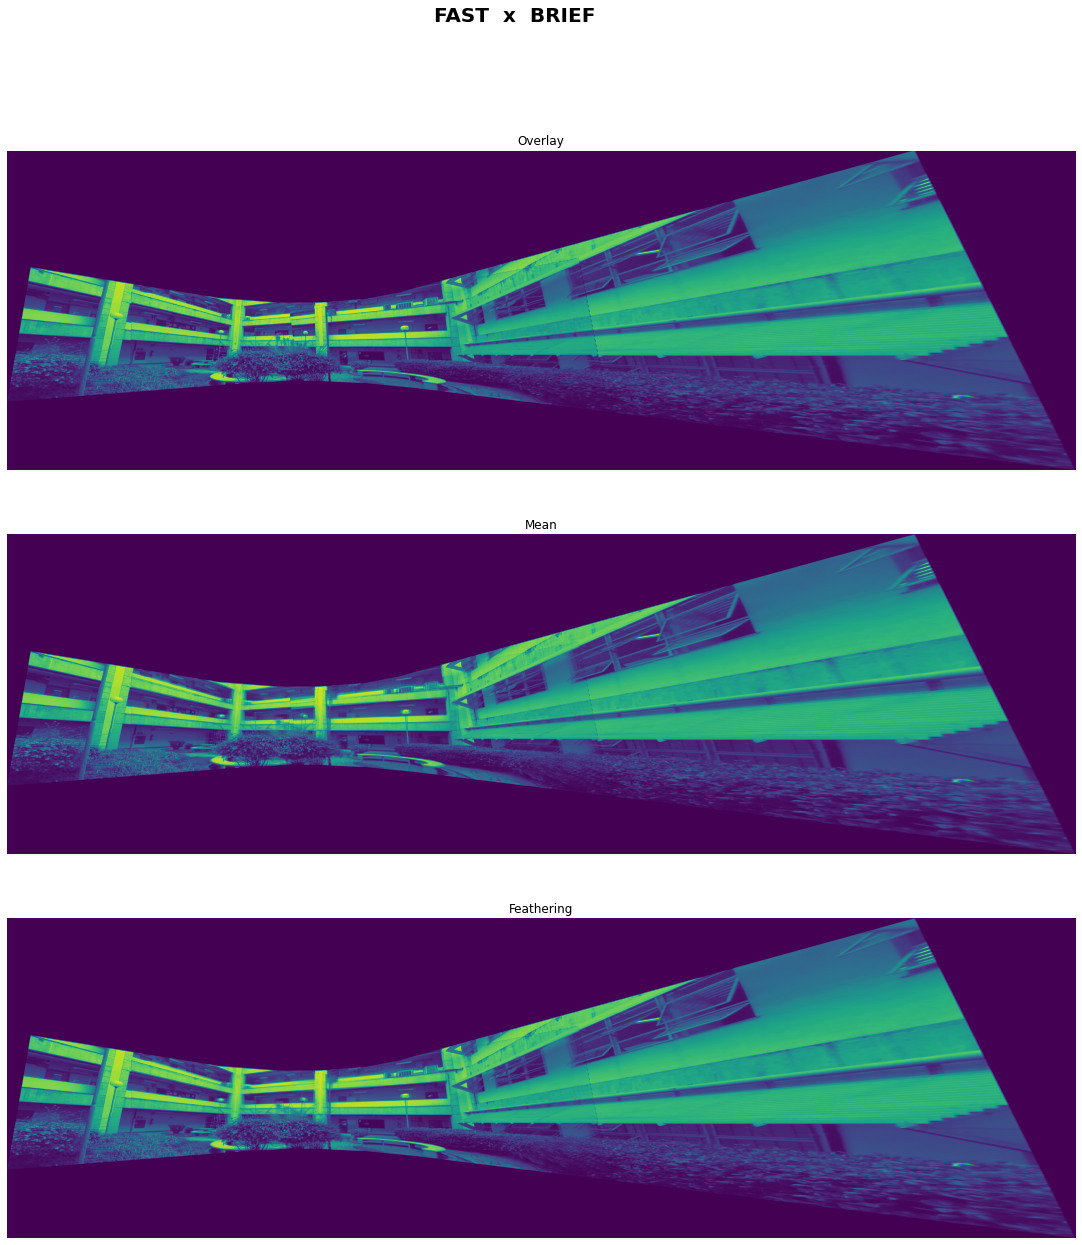

>>      Mean Squared Error:
>>      Overlay: 84.075052
>>      Mean: 83.870855
>>      Feathering: 83.932539
>>      Generating difference images:
>>        - Overlay image done!
>>        - Mean image done!
>>        - Feathering image done!


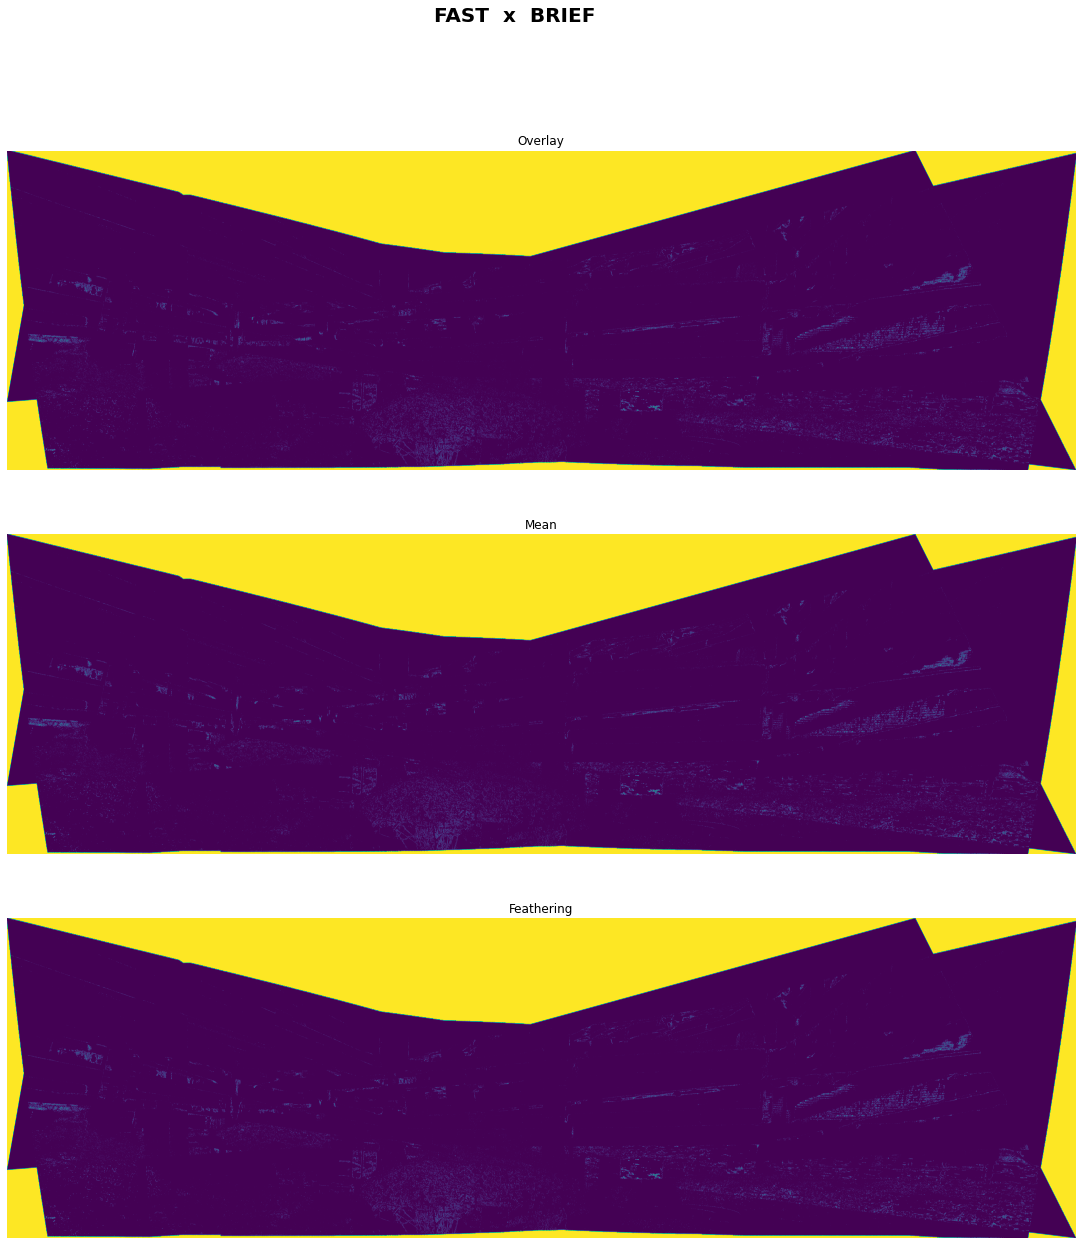

>>  - Detector: ORB
>>  - Descriptor: ORB
>>      Generating mosaic...
>>        Stitching image 1 to image 0 by the right side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>        Stitching image 3 to image 2 by the right side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>        Stitching image 4 to image 5 by the left side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>        Stitching pair 1,0 to pair 3,2 by the left side...
>>          Getting homography matrix
>> 

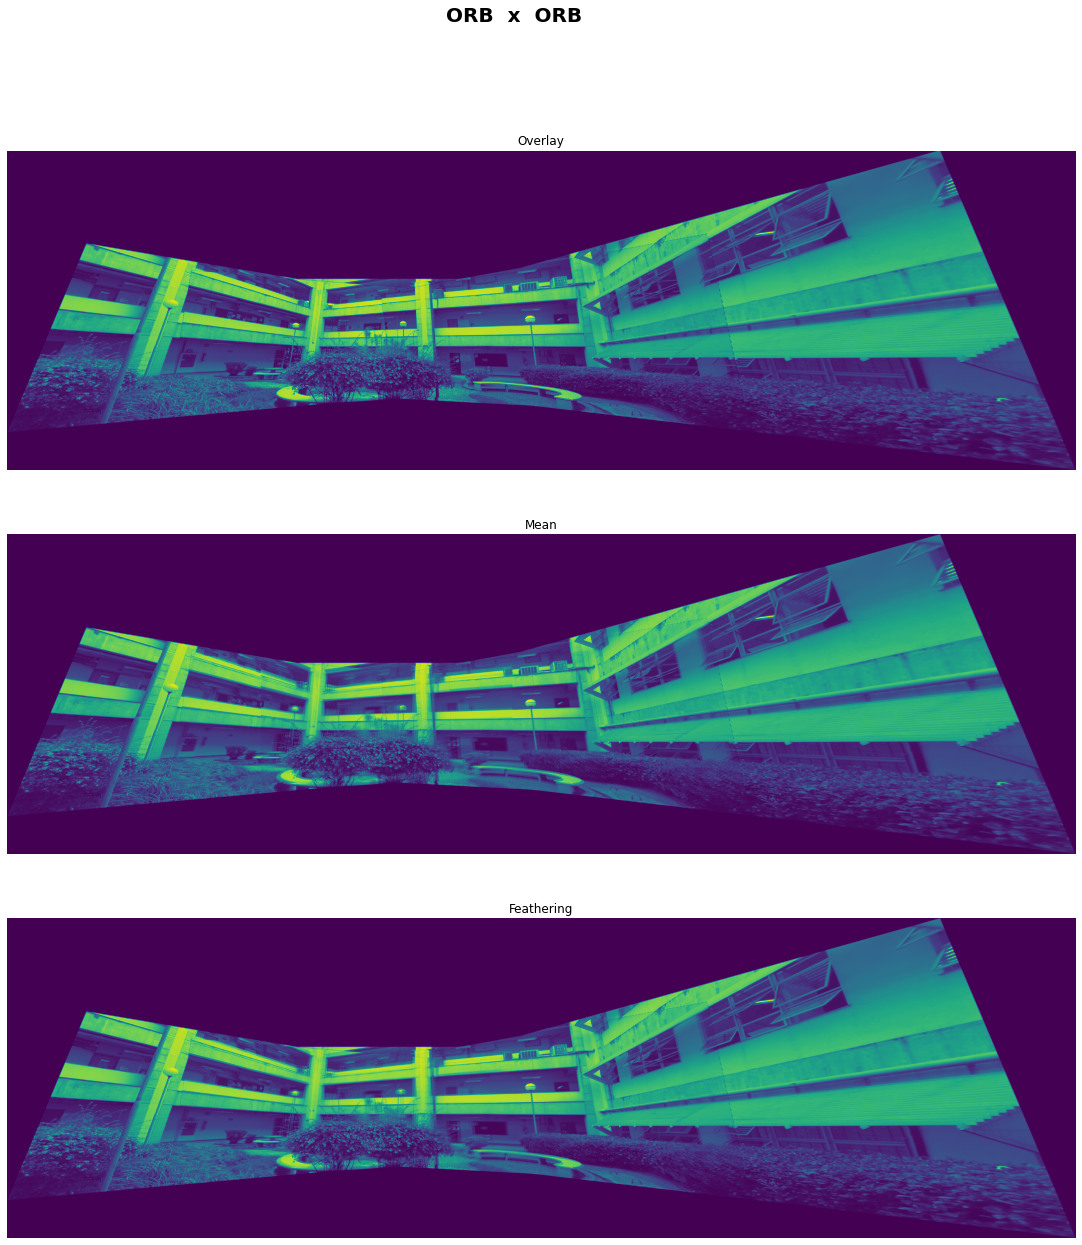

>>      Mean Squared Error:
>>      Overlay: 81.674641
>>      Mean: 81.427412
>>      Feathering: 81.486288
>>      Generating difference images:
>>        - Overlay image done!
>>        - Mean image done!
>>        - Feathering image done!


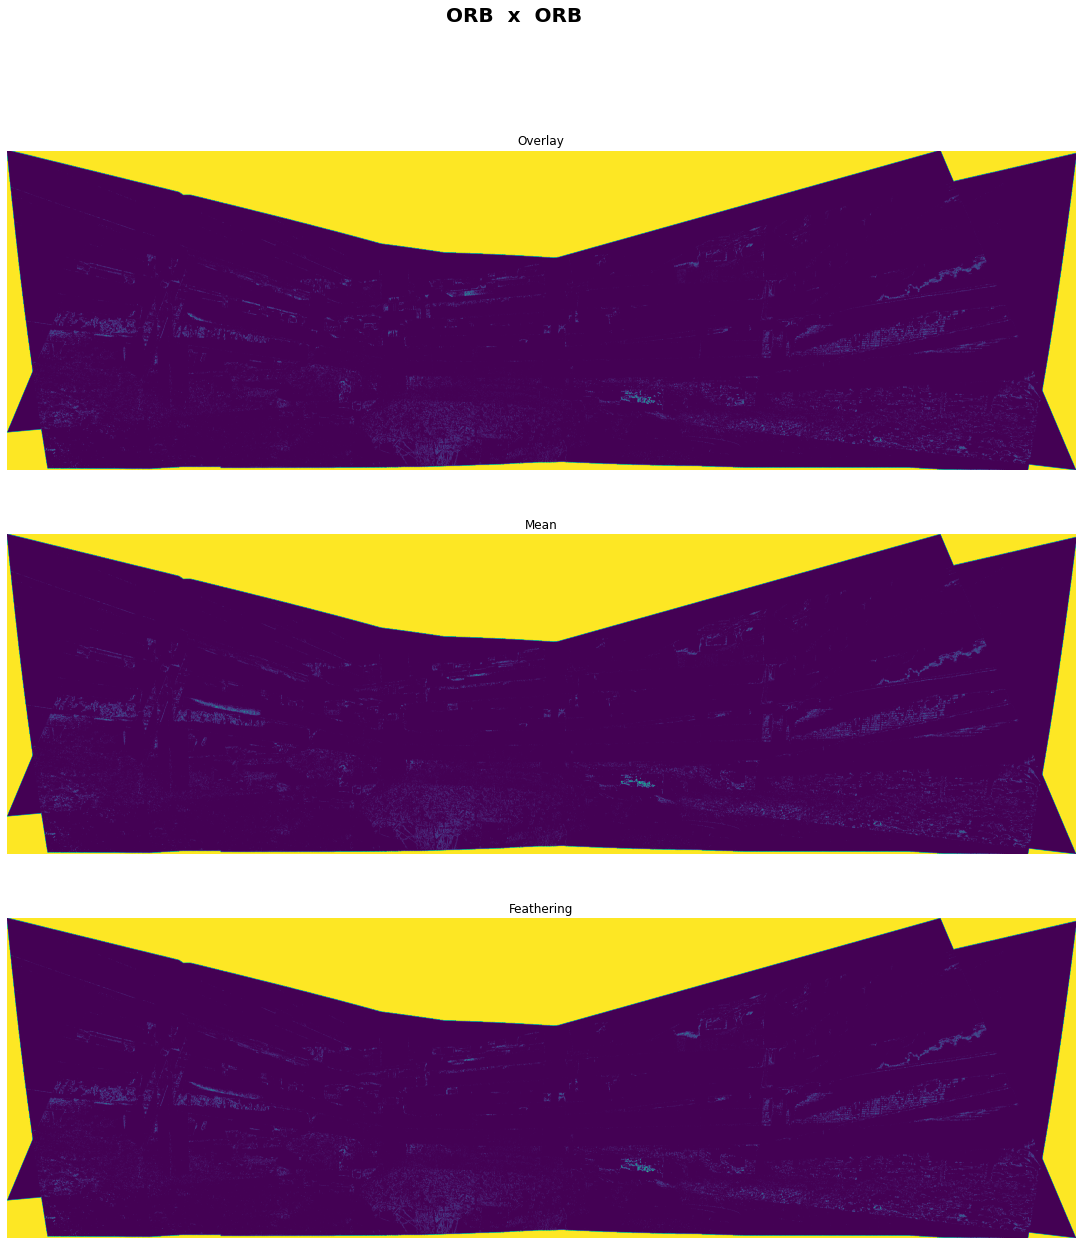

>>  - Detector: SIFT
>>  - Descriptor: SIFT
>>      Generating mosaic...
>>        Stitching image 1 to image 0 by the right side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>        Stitching image 3 to image 2 by the right side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>        Stitching image 4 to image 5 by the left side...
>>          Getting homography matrix
>>          Applying perspective
>>          Stitching with overlay method
>>          Stitching with mean method
>>          Stitching with feathering method
>>        ...done!
>>        Stitching pair 1,0 to pair 3,2 by the left side...
>>          Getting homography matrix
>

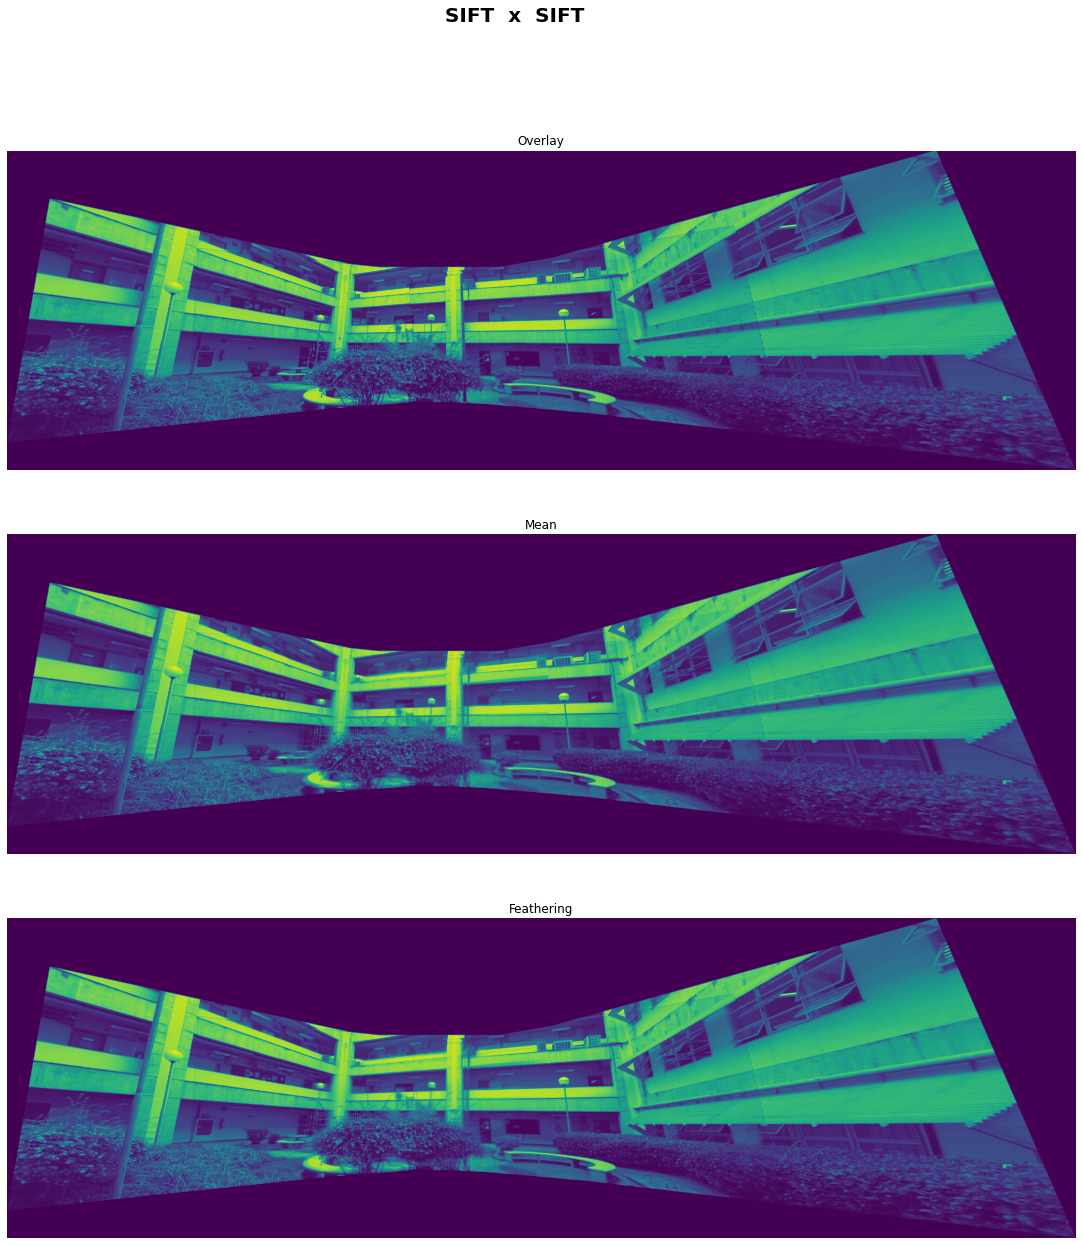

>>      Mean Squared Error:
>>      Overlay: 80.478630
>>      Mean: 80.301689
>>      Feathering: 80.308717
>>      Generating difference images:
>>        - Overlay image done!
>>        - Mean image done!
>>        - Feathering image done!


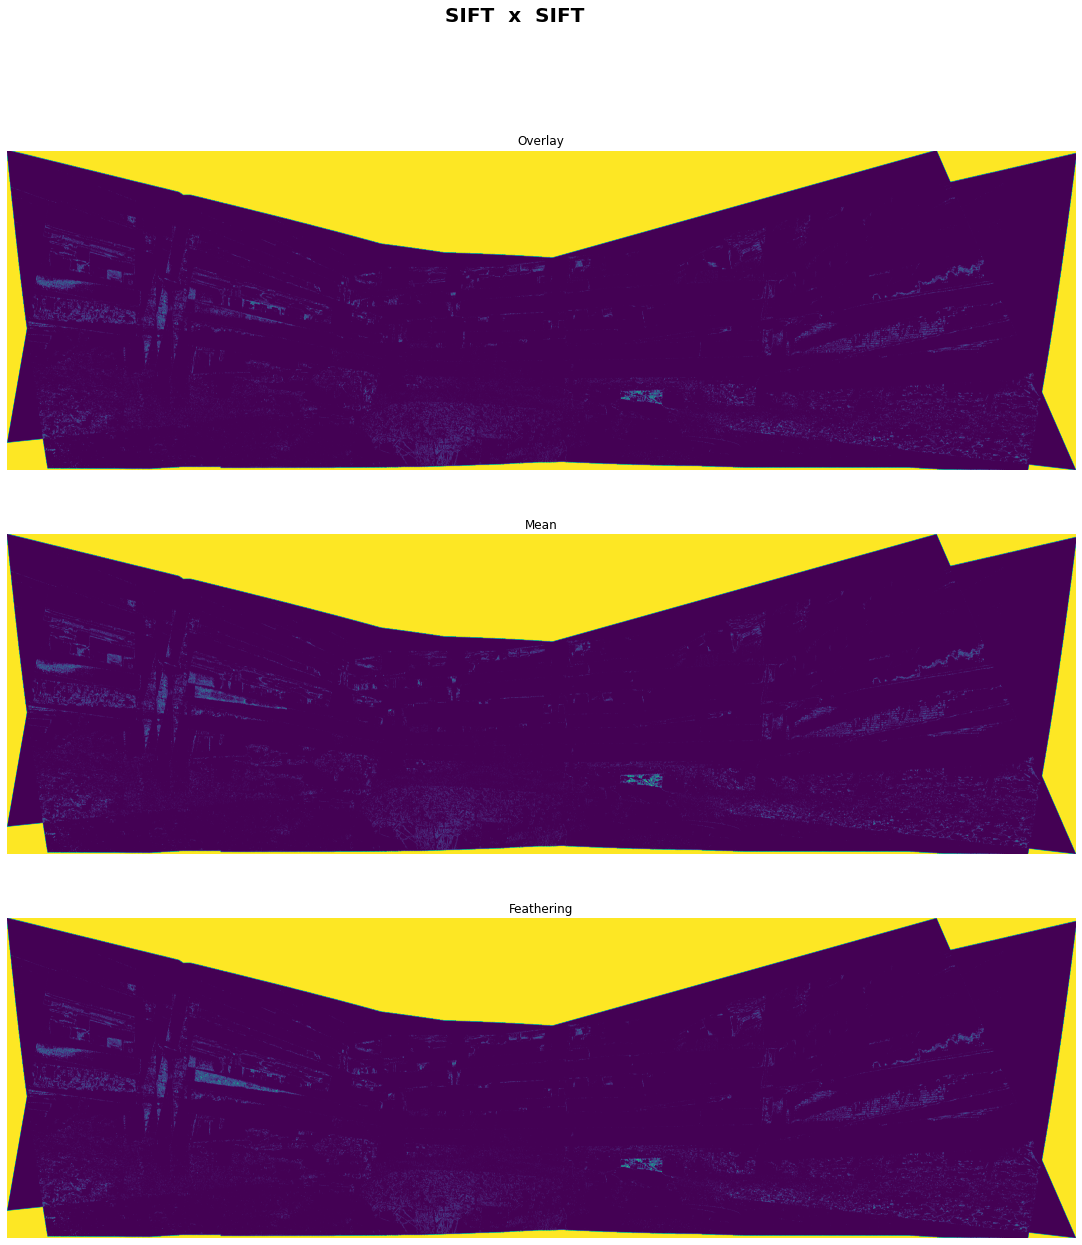

>> ...test pipeline finished!


In [ ]:
print('>> Starting test pipeline...')
print('>>   * Note: Images are big and the processing can take a while')

# Hyperparameters
number_images = 6
number_features = 16000
number_macthes = 4000
scale_percent = 30
show_images = True
save_images = False

list_images = []
list_results = []

detectors_descriptors = [                          
                            ('FAST', 'BRIEF'),
                            ('ORB', 'ORB'),
                            ('SIFT', 'SIFT')
                        ]

for index in range(number_images):

    image = cv2.imread('img' + str(index + 1) + '.jpg', 0)
    image = resize_image(image, scale_percent)
    list_images.append(image)

groundtruth = cv2.imread('groundtruth.jpg', 0)
height, width = groundtruth.shape[0:2]

for pair in detectors_descriptors:
    
    detector, descriptor = pair
    print('>>  - Detector: %s\n>>  - Descriptor: %s' % (detector, descriptor))
    print('>>      Generating mosaic...')
    mosaic_overlay, mosaic_mean, mosaic_feathering = get_mosaic(list_images, detector, descriptor, number_features,number_macthes)
    print('>>      ...done!')

    # Save results
    if(save_images):
        cv2.imwrite('%s_%s_mosaic_overlay.jpg' % (detector, descriptor), mosaic_overlay)
        cv2.imwrite('%s_%s_mosaic_mean.jpg' % (detector, descriptor), mosaic_mean)
        cv2.imwrite('%s_%s_mosaic_feathering.jpg' % (detector, descriptor), mosaic_feathering)

    # Resize to groundtruth dimensions
    resized_overlay = cv2.resize(mosaic_overlay, (width, height), interpolation = cv2.INTER_AREA)
    resized_mean = cv2.resize(mosaic_mean, (width, height), interpolation = cv2.INTER_AREA)
    resized_feathering = cv2.resize(mosaic_feathering, (width, height), interpolation = cv2.INTER_AREA)

    # Show results
    if(show_images):
        fig = plt.figure()
        fig.set_size_inches(30, 20)
        fig.suptitle(detector + '  x  ' + descriptor, fontsize=20, weight='bold')

        ax1 = fig.add_subplot(311)
        plt.axis('off')
        ax1.title.set_text('Overlay')
        ax1.imshow(resized_overlay)
        
        ax2 = fig.add_subplot(312)
        plt.axis('off')
        ax2.title.set_text('Mean')
        ax2.imshow(resized_mean)

        ax3 = fig.add_subplot(313)
        plt.axis('off')
        ax3.title.set_text('Feathering')
        ax3.imshow(resized_feathering)
        plt.show()
        fig.clear()
        plt.close(fig)

    # Get error
    error_overlay = mean_square_error(resized_overlay, groundtruth)
    error_mean = mean_square_error(resized_mean, groundtruth)
    error_feathering = mean_square_error(resized_feathering, groundtruth)
    print('>>      Mean Squared Error:\n>>      Overlay: %f\n>>      Mean: %f\n>>      Feathering: %f' % (error_overlay, error_mean, error_feathering))

    # Get difference
    print('>>      Generating difference images:')
    difference_overlay = get_difference(resized_overlay, groundtruth, 15)
    print('>>        - Overlay image done!')
    difference_mean = get_difference(resized_mean, groundtruth, 15)
    print('>>        - Mean image done!')
    difference_feathering = get_difference(resized_feathering, groundtruth, 15)
    print('>>        - Feathering image done!')

    # Save differences
    if(save_images):
        cv2.imwrite('%s_%s_difference_overlay.jpg' % (detector, descriptor), difference_overlay)
        cv2.imwrite('%s_%s_difference_mean.jpg' % (detector, descriptor), difference_mean)
        cv2.imwrite('%s_%s_difference_feathering.jpg' % (detector, descriptor), difference_feathering)

    # Show differences
    if(show_images):
        fig = plt.figure()
        fig.set_size_inches(30, 20)
        fig.suptitle(detector + '  x  ' + descriptor, fontsize=20, weight='bold')

        ax1 = fig.add_subplot(311)
        plt.axis('off')
        ax1.title.set_text('Overlay')
        ax1.imshow(difference_overlay)
        
        ax2 = fig.add_subplot(312)
        plt.axis('off')
        ax2.title.set_text('Mean')
        ax2.imshow(difference_mean)

        ax3 = fig.add_subplot(313)
        plt.axis('off')
        ax3.title.set_text('Feathering')
        ax3.imshow(difference_feathering)
        plt.show()
        fig.clear()
        plt.close(fig)

print('>> ...test pipeline finished!')

## **Report**

### **Main Functions**

- **get_correspondences:** Receives two images and detects keypoints on both using the specified detector type and the limit number of features. Next, it generates the descriptors for both keypoints sets using the specified descriptor type. Finally, it matches the descriptors with *cv2.BFMatcher* and returns both keypoints sets along with the specified number of best matches ordered by lower distance.

- **match_points:** Receives two sets of keypoints and a set of matches and returns two lists of keypoints ordered by their respective matches.

- **get_homography:** Receives the source and destination images, detector and descriptor types, and the limit numbers for features and matches. Using the previous functions, it obtains matching points and uses them to calculate the homography matrix with *cv2.findHomography*.

- **get_perspective:** Receives an image and projects it using the given homography matrix. The offsets for x and y are obtained by first projecting the image corners with *cv2.perspectiveTransform* and them getting the negative values. Next we use the offsets to adjust the homography matrix adding translation, and finally we project the whole image with *cv2.warpPerspective*.

- **stitch_images:** Receives source and destination images, the projected corners from source image, a direction and a blending method. The source image is stitched on the destination one by the given direction (left or right) and using the given blending method (none, mean, feathering). The projected corners information is used to obtain offset values and correctly align the images.

### **Walkthrough:**

1. For each consecutive pair of images, define source and destination, and then obtain the homography for the source image using *get_homography*
2. Apply the perspective on the source image with *get_perspective*
3. Stitch the source image to the destination image using *stitch_images*
4. Form new pairs with the generate images and repeat until there is only one image left

### **Results**

**_Mean Squared Error_**

- FAST and BRIEF:

```text
    - Overlay: 84.075052
    - Mean: 83.870855
    - Feathering: 83.932539
```

- ORB and ORB:

```text
    - Overlay: 81.674641
    - Mean: 81.427412
    - Feathering: 81.486288
```

- SIFT and SIFT:

```text
    - Overlay: 80.478630
    - Mean: 80.301689
    - Feathering: 80.308717
```

**_Difference Images_**

> ⚠️ **DIFFERENCE IMAGES ALONG WITH RESULTS ARE PLOTTED ON THE ABOVE CELL!**

## **Discussion**

### **Implementation**

- When projected, the points from the source image that do not appear on the destination image are projected to negative coordinates. We can fix this by adding some translation value in the homography matrix, so the whole image is projected correctly. This offset value is obtained by first projecting the corners of the image only, and checking the lowest negative value.

- The images that are going to be merged need to have an overlapping area, so we can find good keypoints matches. Better matches leads to a better homograpy matrix, so we need to avoid wrong correspondences. This is why we limit the number of matches, picking only the best quality (lower distance) ones.

- There are several possible orders to stitch the images together and this heavily influence the outcome. For this experiment we found that stacking each consecutive pair of neighbor images first, and then adding the left and right pairs to the central one was the best option. This sequence resulted in lower distortion and error, when compare to the ground truth.

- For the difference image implementation, we set every pixel with the exact same value of white, and all the others in black.

### **Results**

- The results were obtained with a fixed number of detected keypoints and matches to reduce computational cost, since the images are big, and to compare the quality of the features extracted.

- SIFT and SIFT was the best combination, showing the lowest error, next we have ORB and ORB and finally FAST and BRIEF, what makes sense, since ORB is an improved combination of both. These results indicates that SIFT was more precise in detecting and describing the same points, especially on the last stitch, when the images are more distorted. This means that SIFT is more robust to noise and distortion, but the other two combinations are much faster, since they are binary descriptors.

- The mean and feathering blending methods reduced the error in all cases, but also the difference between those two was minimal for this specific mosaic.

- Finally, the difference images show closer SIFT was to the ground truth, showing much more with dots, that indicates correct pixels.
